In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import calendar
import random 
import seaborn as sn
import itertools
from dateutil.parser import parse

from sklearn.model_selection import train_test_split

!chcp 65001
!sqlcmd -f 65001 -S tsc-backend-eastus.database.windows.net -U tscadmin -P FI])U6EiM5QMrmG -d shallowcopy-sdh -s"|" -k1 -W -Q "SELECT o.AccountId, o.OpportunityId , o.CreatedDate, o.ActualCloseDate, o.EstimatedCloseDate, HasCustomerAgreedToBuy, o.CreatedById, o.EstimatedValue, o.ActualValue, a.CreatedDate as AccountCreatedDate, a.City as AccountCity, a.EndCustomerSegmentSeqNo, a.EndCustomerSubsegmentSeqNo, a.IndustrySeqNo, a.IndustryVerticalSeqNo, a.VerticalCategorySeqNo, p.PfamSkid, p.PoolSeqNo, p.ProdSkid, p.ProductNumber, p.ProductStructureSeqNo, p.ProductTypeSeqNo FROM [dbo].[Hub_vw_Opportunity] o (nolock) JOIN [dbo].[Hub_vw_OpportunityProduct] op (nolock) on op.OpportunityId = o.OpportunityId JOIN [dbo].[Hub_vw_Product] p (nolock) on op.ProductId = p.ProductId JOIN [dbo].[Hub_vw_Account] a (nolock) on o.AccountId = a.AccountId WHERE a.Country = 'United States' and a.CurrencyId = 'FF2971D7-B412-E411-8D49-6C3BE5A82B68' " >oppty_join.csv


In [2]:
   
#opt = pd.read_csv("d:/repos/forecast/data/oppty_join.csv", sep="|", skiprows=[1], error_bad_lines=True, encoding='iso-8859-1')
date_columns = ['CreatedDate', 'EstimatedCloseDate','ActualCloseDate', 'AccountCreatedDate']

opt = pd.read_csv("d:/repos/forecast/data/oppty_join.csv", sep="|", skiprows=[1], parse_dates=date_columns)#, , date_parser = xplow_memory=False)
#opt.dropna(inplace=True)
opt["EstimatedCloseDate"] = pd.to_datetime(opt['EstimatedCloseDate'], errors="coerce")

opt["actual_days_to_close"] = (opt['ActualCloseDate'] - opt['CreatedDate']).astype('timedelta64[D]')
opt["est_days_to_close"] = (opt['EstimatedCloseDate'] - opt['CreatedDate']).astype('timedelta64[D]')

l = len(opt)
opt.drop( opt[(opt['actual_days_to_close'] > 365*5)].index, inplace=True)
opt.drop( opt[(opt['actual_days_to_close'] < 0)].index, inplace=True)
print('dropped negative close dates and date very distant: ', l-len(opt))
l = len(opt)
opt.drop( opt[(opt['est_days_to_close'] > 365*5)].index, inplace=True)
opt.drop( opt[(opt['est_days_to_close'] < 0)].index, inplace=True)
print('dropped: ', l-len(opt))

opt["AccountCreatedYear"] = opt["AccountCreatedDate"].apply(lambda x: x.year)
opt["CreatedMonth"] = opt["CreatedDate"].apply(lambda x: x.month)
opt[opt["PoolSeqNo"].isna()] = 0

l = len(opt)
# if oppty closed the same date it was created there is no need to predict that date
opt = opt[opt['actual_days_to_close'] > 0]
print('dropped actual days=0: ', l-len(opt))

opt.loc[opt["AccountCity"].isna(), ["AccountCity"]] = "nan"
opt.loc[opt["IndustrySeqNo"].isna(), ["IndustrySeqNo"]] = "nan"



D:\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dropped negative close dates and date very distant:  61046
dropped:  49488
dropped actual days=0:  1370431


In [3]:
def bucket_days(x):
    if (x < 60): return 1
    if (x < 120): return 2
    if (x < 240): return 3
    if (x < 365): return 4
    return 5

opt['days_to_close_bucket'] = opt['actual_days_to_close'].apply(lambda x: bucket_days(x))

opt.describe()

,HasCustomerAgreedToBuy,EstimatedValue,ActualValue,EndCustomerSegmentSeqNo,EndCustomerSubsegmentSeqNo,IndustryVerticalSeqNo,VerticalCategorySeqNo,PoolSeqNo,ProductStructureSeqNo,ProductTypeSeqNo,actual_days_to_close,est_days_to_close,AccountCreatedYear,CreatedMonth,days_to_close_bucket
count,1.592264e+06,2.163602e+06,2.011895e+06,2.163658e+06,2.163658e+06,2.131062e+06,2.131067e+06,2.163658e+06,2163658.0,2163658.0,2.163658e+06,2.159729e+06,2.163658e+06,2.163658e+06,2.163658e+06
mean,2.991966e-03,4.292855e+05,4.079821e+05,5.081768e+03,5.158744e+03,5.076633e+02,1.811047e+02,5.618930e+02,3084.0,334.0,2.481201e+02,2.508111e+02,2.003912e+03,5.424129e+00,3.351628e+00
std,5.461700e-02,7.296680e+06,2.706817e+06,1.462755e+00,2.382347e+02,1.172074e+03,7.066059e+02,6.447971e-01,0.0,0.0,1.666852e+02,1.557719e+02,5.215266e+00,2.914334e+00,1.263927e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,5.080000e+03,5.087000e+03,1.970000e+02,1.100000e+01,5.610000e+02,3084.0,334.0,1.000000e+00,0.000000e+00,1.998000e+03,1.000000e+00,1.000000e+00
25%,0.000000e+00,1.168300e+04,1.144920e+03,5.080000e+03,5.090000e+03,2.110000e+02,3.800000e+01,5.620000e+02,3084.0,334.0,1.260000e+02,1.370000e+02,2.000000e+03,3.000000e+00,3.000000e+00
50%,0.000000e+00,5.324900e+04,4.020072e+04,5.082000e+03,5.097000e+03,2.260000e+02,8.100000e+01,5.620000e+02,3084.0,334.0,2.320000e+02,2.410000e+02,2.002000e+03,4.000000e+00,3.000000e+00
75%,0.000000e+00,1.917090e+05,1.755480e+05,5.082000e+03,5.099000e+03,2.440000e+02,1.190000e+02,5.620000e+02,3084.0,334.0,3.430000e+02,3.390000e+02,2.007000e+03,8.000000e+00,4.000000e+00
max,1.000000e+00,9.900000e+09,3.375000e+08,5.086000e+03,6.057000e+03,6.106000e+03,5.410000e+03,5.640000e+02,3084.0,334.0,1.825000e+03,1.825000e+03,2.018000e+03,1.200000e+01,5.000000e+00


[1.000e+00 6.200e+01 1.260e+02 1.830e+02 2.320e+02 2.830e+02 3.430e+02
 4.280e+02 1.825e+03]


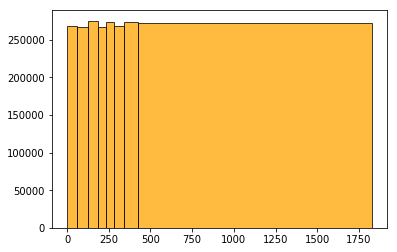

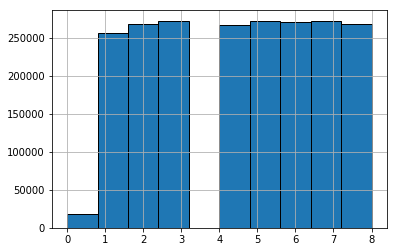

In [4]:
qc = pd.qcut(opt['actual_days_to_close'].values, q=8, duplicates='drop', retbins=True)
bins = qc[1][0:]
plt.hist(opt['actual_days_to_close'], bins=bins,facecolor='orange', alpha=0.75, histtype='bar', ec='black')


def bucket_days2(x):
    r = np.where(bins>=x)[0]
    return r[0] if len(r)>0 else len(bins)

opt['days_to_close_bucket'] = opt['actual_days_to_close'].apply(lambda x: bucket_days2(x))

plt.figure()
opt['days_to_close_bucket'].hist( histtype='bar', ec='black')
print(bins)



array([1, 2, 4, 5, 3], dtype=int64)

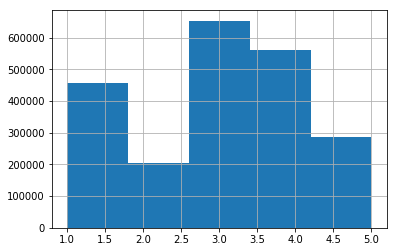

In [5]:
def bucket_value(x):
    if (x == np.nan): return 1
    if (x <=0): return 1
    if (x < 1E4): return 2
    if (x < 1E5): return 3
    if (x < 1E6): return 4
    if (x < 1E7): return 5
    return 5

opt['ActualValue_bucket'] = opt['ActualValue'].apply(lambda x: bucket_value(x))


opt['ActualValue_bucket'].hist(bins=len(opt['ActualValue_bucket'].unique()))
opt['ActualValue_bucket'].unique()

In [6]:
opt.columns

Index(['AccountId', 'OpportunityId', 'CreatedDate', 'ActualCloseDate',
       'EstimatedCloseDate', 'HasCustomerAgreedToBuy', 'CreatedById',
       'EstimatedValue', 'ActualValue', 'AccountCreatedDate', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo', 'actual_days_to_close',
       'est_days_to_close', 'AccountCreatedYear', 'CreatedMonth',
       'days_to_close_bucket', 'ActualValue_bucket'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023957009A90>,
      dtype=object)

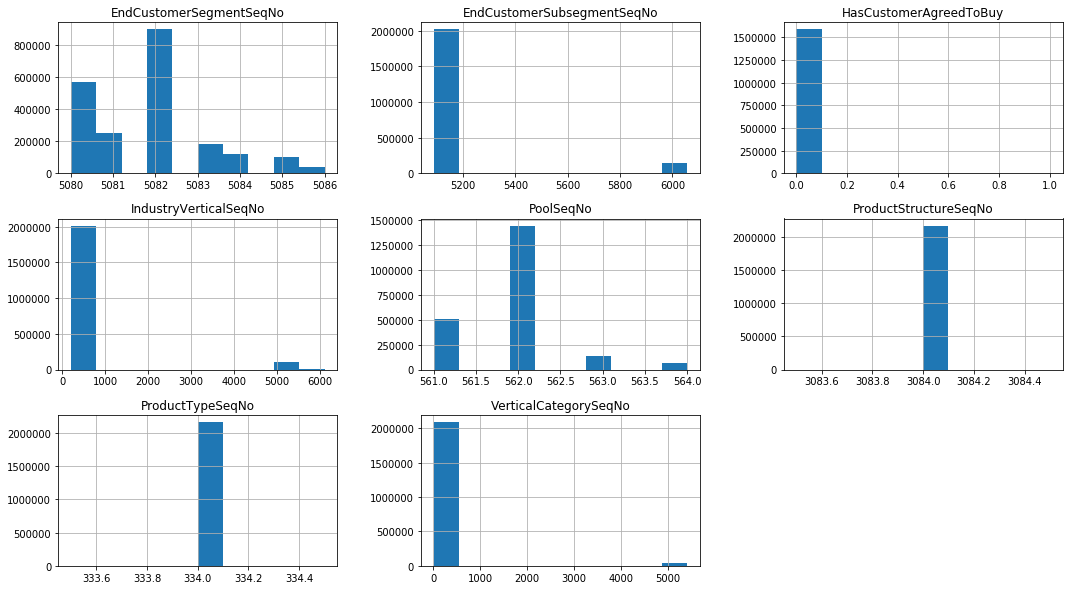

In [7]:
categorical_columns = ['HasCustomerAgreedToBuy', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo']

opt[categorical_columns].hist(figsize=(18,10))

In [8]:
opt["PoolSeqNo"].value_counts()

562.0    1446003
561.0     509021
563.0     139740
564.0      68894
Name: PoolSeqNo, dtype: int64

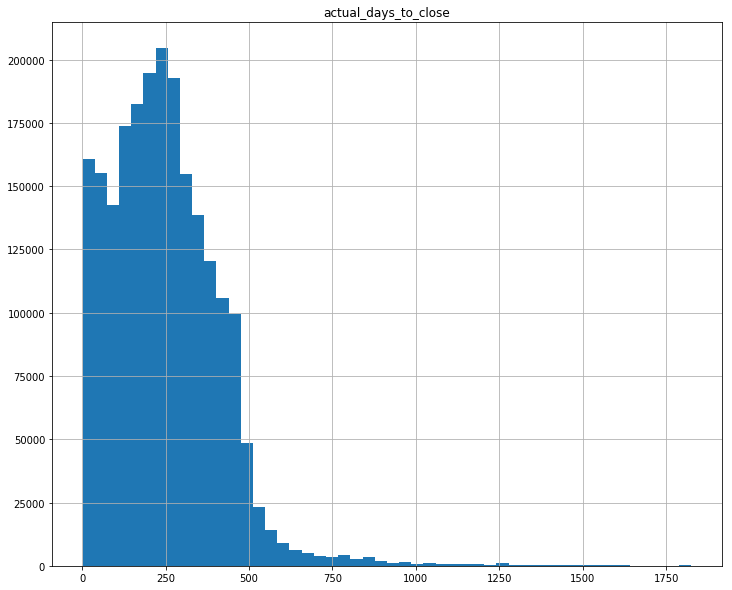

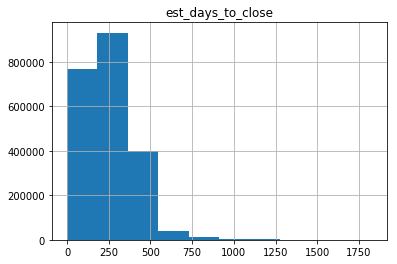

In [9]:
#opt[ ['est_days_to_close', 'actual_days_to_close']]

plt.figure(figsize=(12,10))
plt.title("actual_days_to_close")
opt['actual_days_to_close'].hist(label='x', bins=50)
plt.figure()
plt.title("est_days_to_close")
opt['est_days_to_close'].hist()

In [10]:
categorical_columns = ['CreatedById', 'AccountCity',
       'EndCustomerSegmentSeqNo', 'EndCustomerSubsegmentSeqNo',
       'IndustrySeqNo', 'IndustryVerticalSeqNo', 'VerticalCategorySeqNo',
       'PfamSkid', 'PoolSeqNo', 'ProdSkid', 'ProductNumber',
       'ProductStructureSeqNo', 'ProductTypeSeqNo']

def featurize(opt, cat_features):
    for f in cat_features:
        opt[f] = opt[f].astype('category')

    opt[cat_features] = opt[cat_features].apply(lambda x: x.cat.codes)

    opt = opt.drop( opt[opt["actual_days_to_close"].isna()].index )

    return opt

opt = featurize(opt, categorical_columns)

In [11]:
def train_test(opt, features, label):
    X = opt[features]
    y = opt[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    #print(f"Training Size: {len(X_train):,}")
    #print(f"Testing Size.: {len(X_test):,}")
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = build_train_test(opt, cat_features)
# pd.concat([X_train, y_train], axis=1, sort=False).head()


In [12]:
opt["CreatedById"].dtype

dtype('int16')

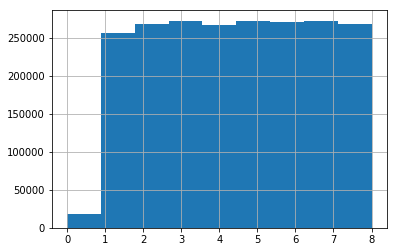

In [13]:
nbins = len(opt['days_to_close_bucket'].unique())
opt['days_to_close_bucket'].hist(bins=nbins)

In [14]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

In [15]:
# evaluate single features
def train_single_feature(df, feature_name, label):
   
    df = df[[feature_name, label]].copy()
    
        
    X_train, X_test, y_train, y_test = train_test(df, [feature_name], label)
    
    model = tree.DecisionTreeClassifier(max_depth=5)
    try:
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        # print("Accuracy: {:.4f}".format(acc))
    except Exception as ex:
        print("Error: ", feature_name, ex)
        acc = 0
        
    return acc
    
def evaluate_features(df, features, label):
    
    scores = [(f, train_single_feature(df, f, label)) for f in features]
    scores = [(f,s) for f,s in scores if s > 0]
    scores.sort(reverse=True, key = lambda x: x[1])
    return (scores)
    
columns_to_evaluate = opt.columns

label = ""
scores = evaluate_features(opt, columns_to_evaluate, label="days_to_close_bucket")

print("\n")
scores

Error:  AccountId could not convert string to float: 'AAE29AEA-1EE0-4684-BAF9-1E91489184ED'
Error:  OpportunityId could not convert string to float: 'F2BAA4A9-A7D5-4EB1-8DE9-7AE23A0AA5DC'
Error:  CreatedDate float() argument must be a string or a number, not 'Timestamp'
Error:  ActualCloseDate float() argument must be a string or a number, not 'Timestamp'
Error:  EstimatedCloseDate float() argument must be a string or a number, not 'Timestamp'
Error:  HasCustomerAgreedToBuy Input contains NaN, infinity or a value too large for dtype('float32').
Error:  EstimatedValue Input contains NaN, infinity or a value too large for dtype('float32').
Error:  ActualValue Input contains NaN, infinity or a value too large for dtype('float32').
Error:  AccountCreatedDate float() argument must be a string or a number, not 'Timestamp'
Error:  est_days_to_close Input contains NaN, infinity or a value too large for dtype('float32').
Error:  days_to_close_bucket multiclass-multioutput is not supported




[('actual_days_to_close', 0.8731932620343923),
 ('CreatedMonth', 0.2091024775919815),
 ('CreatedById', 0.20031027672246718),
 ('EndCustomerSubsegmentSeqNo', 0.1907554791418245),
 ('IndustrySeqNo', 0.18068149955784796),
 ('ActualValue_bucket', 0.1786309617345917),
 ('VerticalCategorySeqNo', 0.17599961793134472),
 ('IndustryVerticalSeqNo', 0.1726272458087993),
 ('AccountCreatedYear', 0.17234531611559425),
 ('EndCustomerSegmentSeqNo', 0.16399988907684201),
 ('PfamSkid', 0.16300466185383408),
 ('ProductNumber', 0.1553263143623921),
 ('ProdSkid', 0.15450517487343976),
 ('AccountCity', 0.13452360044246015),
 ('PoolSeqNo', 0.12976468884513587),
 ('ProductStructureSeqNo', 0.12485017670675307),
 ('ProductTypeSeqNo', 0.12485017670675307)]

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Dummy Classifier

In [19]:
# dummy 

# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']

cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth"]

features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

strategies = ["stratified", "most_frequent", "prior", "uniform"]
for strategy in strategies:
    model = DummyClassifier(strategy=strategy)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print("Strategy: {:20}   Accuracy: {:.4f} ***".format(strategy, acc))



Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth'],
      dtype='object')
X_train 1,514,560
Strategy: stratified             Accuracy: 0.1235 ***
Strategy: most_frequent          Accuracy: 0.1249 ***
Strategy: prior                  Accuracy: 0.1249 ***
Strategy: uniform                Accuracy: 0.1112 ***


# Single Decision Tree

In [20]:
# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']
cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth", "PoolSeqNo"]#, "ProductTypeSeqNo"]
features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
#model = ensemble.GradientBoostingClassifier(**params)
model = tree.DecisionTreeClassifier() #max_depth=2)


model.fit(X_train, y_train)

acc = model.score(X_test, y_test)

print("Accuracy: {:.4f} ***".format(acc))

y_pred = model.predict(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test))
print(sk_report)

print(confusion_matrix(y_test, y_pred))

print(dict(zip(X_train.columns, model.feature_importances_)))


Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth',
       'PoolSeqNo'],
      dtype='object')
X_train 1,514,560
Accuracy: 0.8627 ***
             precision    recall  f1-score   support

          0   0.872340  0.886112  0.879172      5321
          1   0.816156  0.814545  0.815350     76989
          2   0.825828  0.825366  0.825597     80500
          3   0.854651  0.858564  0.856603     81040
          4   0.870176  0.870047  0.870111     80552
          5   0.883538  0.884035  0.883787     81775
          6   0.886444  0.878984  0.882698     80799
          7   0.890049  0.887719  0.888882     81750
          8   0.871033  0.877557  0.874283     80372

avg / total   0.862666  0.862651  0.862654    649098

[[ 4715   352   101    46    24    15    13    25    30]
 [  390 62711  5109  2419  1438  1211   999   993  1719]
 [  119  5291 66442  2586  1484  1203  1031  1002  1342]
 

# Random Forest

Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth'],
      dtype='object')
X_train 1,514,560
Accuracy: 0.8746 ***
             precision    recall  f1-score   support

          0   0.935240  0.884796  0.909319      5321
          1   0.803918  0.854979  0.828663     76989
          2   0.839599  0.835354  0.837471     80500
          3   0.873273  0.866732  0.869991     81040
          4   0.894745  0.875062  0.884794     80552
          5   0.904958  0.891446  0.898151     81775
          6   0.898412  0.887004  0.892671     80799
          7   0.903254  0.894691  0.898952     81750
          8   0.875970  0.889103  0.882488     80372

avg / total   0.875274  0.874557  0.874781    649098

[[ 4708   398    87    43    17    15    10    13    30]
 [  201 65824  4449  1865   938   851   716   690  1455]
 [   47  6073 67246  2378  1125   921   828   762  1120]
 [   27  2636  2430 7

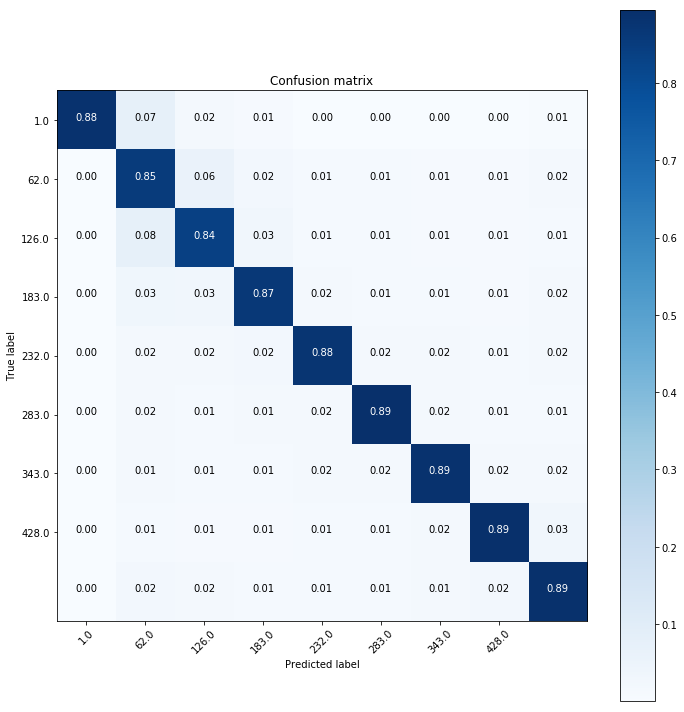

In [23]:
# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']

cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth"]

features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

model = ensemble.RandomForestClassifier(n_estimators=35, n_jobs=-1)

model.fit(X_train, y_train)

acc = model.score(X_test, y_test)

print("Accuracy: {:.4f} ***".format(acc))

y_pred = model.predict(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test))
print(sk_report)

print(confusion_matrix(y_test, y_pred))

print(dict(zip(X_train.columns, model.feature_importances_)))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, bins[:-1], normalize=True)

In [24]:
bins

array([1.000e+00, 6.200e+01, 1.260e+02, 1.830e+02, 2.320e+02, 2.830e+02,
       3.430e+02, 4.280e+02, 1.825e+03])

# AdaBoost


In [25]:
# baseline 
#cat_features = ["AccountCity", 'ProductNumber', "IndustrySeqNo", "CreatedById", "EndCustomerSubsegmentSeqNo", 'ProductStructureSeqNo']

cat_features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth"]

features = cat_features
label = "days_to_close_bucket"

X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

print("Features", X_train.columns)
print("X_train {:,}".format(len(X_train)))

model = ensemble.AdaBoostClassifier(
                    tree.DecisionTreeClassifier(max_depth=2),
                    n_estimators=600,
                    learning_rate=1.0,
                    algorithm="SAMME")

model.fit(X_train, y_train)

acc = model.score(X_test, y_test)

print("Accuracy: {:.4f} ***".format(acc))

y_pred = model.predict(X_test)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test))
print(sk_report)

print(confusion_matrix(y_test, y_pred))

print(dict(zip(X_train.columns, model.feature_importances_)))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, bins[:-1], normalize=True)

Features Index(['AccountCity', 'AccountCreatedYear', 'IndustrySeqNo', 'CreatedById',
       'EndCustomerSubsegmentSeqNo', 'ActualValue_bucket', 'CreatedMonth'],
      dtype='object')
X_train 1,514,560


KeyboardInterrupt: 

# Regression

In [27]:
import  torch
import  torch.nn  as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

In [94]:
cuda = torch.cuda.is_available()
seed = 42
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
print("Cuda:", cuda)

Cuda: True


In [86]:
# convert data
from sklearn.preprocessing import OneHotEncoder

features = ["AccountCity",  "AccountCreatedYear", "IndustrySeqNo", "CreatedById", 
                "EndCustomerSubsegmentSeqNo", "ActualValue_bucket", "CreatedMonth"]

label = "actual_days_to_close"
ov = opt[features].values

total = 0
#for feature in features:
#    l = len(opt[feature].unique())
#    total += l
#    print("{:30} {}".format(feature,l))
#print("{:30} {}".format("Total", total))

enc = OneHotEncoder(dtype=np.float32)
enc.fit(ov)  

#print(enc.n_values_)
#print(enc.feature_indices_)

x_train = enc.transform(ov[0:100]).toarray() 
y_true = opt.iloc[0:100][label].values.astype(np.float32).reshape(-1, 1)
len(x_train[0])

def get_batch(x, y, batch_size = 100):
    rows = np.random.randint(0, high=len(x), size=batch_size)
    return (x.iloc[rows], y.iloc[rows])

def onhot_encode(df, enc):
    x = enc.transform(df).toarray()
    return x

In [95]:
class LinearRegressionModel(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(LinearRegressionModel, self).__init__() 
        
        self.linear = nn.Linear(input_dim, output_dim)
                
        if torch.cuda.is_available():
            self.linear.cuda()
        
        self.net = self.linear

    def forward(self, x):
        out = self.net(x)
        return out


In [113]:
# prepare a sample so we can get the dimension
X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

x, _ = get_batch(X_train, y_train)
x_train = onhot_encode(x, enc)
input_dim = len(x_train[0])

model = LinearRegressionModel(input_dim, 1)

criterion = nn.MSELoss()
l_rate = 0.01
optimiser = torch.optim.SGD(model.parameters(), lr = 0.001) #Stochastic Gradient Descent
#optimiser = torch.optim.Adam(model.parameters(), lr = 0.001)


epochs = 100000

In [ ]:
X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

for epoch in range(epochs):

    epoch +=1
    X, y = get_batch(X_train, y_train)
    
    xt = onhot_encode(X, enc)
    yt = y.values.astype(np.float32).reshape(-1, 1)
    
    inputs = Variable(torch.from_numpy(xt)).cuda()
    labels = Variable(torch.from_numpy(yt)).cuda()

    # clear gradients
    optimiser.zero_grad()
    # get predicted values
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimiser.step()
    if (epoch % 1000 == 0):
        print('epoch {}, loss {}'.format(epoch,loss.data.item()))

epoch 1000, loss 24156.650390625
epoch 2000, loss 25161.0546875
epoch 3000, loss 19958.861328125
epoch 4000, loss 16646.7109375
epoch 5000, loss 23620.890625
epoch 6000, loss 13608.1103515625
epoch 7000, loss 30719.9296875
epoch 8000, loss 18212.39453125
epoch 9000, loss 26118.97265625
epoch 10000, loss 12199.73046875
epoch 11000, loss 14873.853515625
epoch 12000, loss 20833.98828125
epoch 13000, loss 14238.9560546875
epoch 14000, loss 13770.4697265625
epoch 15000, loss 20922.375
epoch 16000, loss 17717.294921875
epoch 17000, loss 29288.5546875
epoch 18000, loss 18626.88671875
epoch 19000, loss 15897.13671875
epoch 20000, loss 26638.962890625
epoch 21000, loss 22021.8671875
epoch 22000, loss 22788.490234375
epoch 23000, loss 25055.494140625
epoch 24000, loss 32571.08984375
epoch 25000, loss 23214.7265625
epoch 26000, loss 34897.6015625
epoch 27000, loss 22160.259765625
epoch 28000, loss 12827.57421875
epoch 29000, loss 17456.314453125
epoch 30000, loss 14126.646484375
epoch 31000, loss

In [105]:
tolerance = 0.1
correct  = 0
total = 1000

xt= X_train
yt = y_train

with torch.no_grad():
    for _ in range(total):
        n = np.random.randint(len(xt))
        x = onhot_encode(xt.iloc[n:n+1], enc)        
        inputs = Variable(torch.from_numpy(x)).cuda()
        p = model.forward(inputs).item()
        t = yt.iloc[n]
        error = abs(p-t)/(t+0.00001)
        #print(p, t, error)
        if error < tolerance:
            correct += 1
    
    print (correct/total)
    


0.136


# SGDClassifier

In [106]:
from sklearn.linear_model import SGDClassifier

In [ ]:
   
X_train, X_test, y_train, y_test = train_test(opt, features, label) # .sample(n=1500000)

model = SGDClassifier(loss='log')

for epoch in range(epochs):

    epoch +=1
    X, y = get_batch(X_train, y_train)
    
    xt = onhot_encode(X, enc)
    yt = y.values.astype(np.float32).reshape(-1, 1)
    model.partial_fit(xt, yt)
    


In [ ]:
tolerance = 0.1
correct  = 0
total = 1000

xt= X_train
yt = y_train


for _ in range(total):
    n = np.random.randint(len(xt))
    x = onhot_encode(xt.iloc[n:n+1], enc)        
    
    p = model.predict(x)
    t = yt.iloc[n]
    error = abs(p-t)/(t+0.00001)
    #print(p, t, error)
    if error < tolerance:
        correct += 1

print (correct/total)
    